# ARCH Modeling

_This setup code is required to run in an IPython notebook_

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 6.0)
pylab.rcParams['savefig.dpi'] = 90

try:
    import seaborn
except ImportError:
    pass

Populating the interactive namespace from numpy and matplotlib


### Setup

These examples will all make use of financial data from Yahoo! Finance imported using `pandas`.  

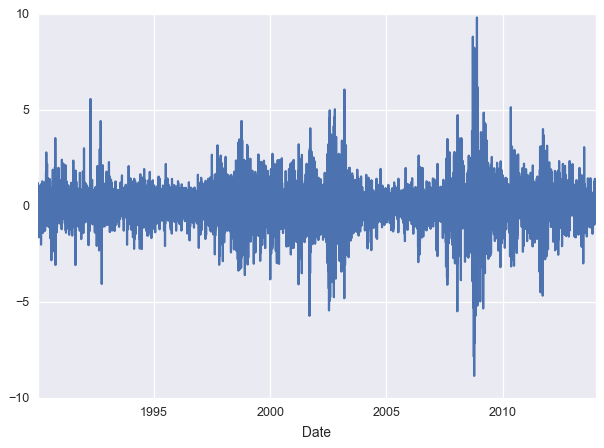

In [2]:
import datetime as dt
import pandas.io.data as web
st = dt.datetime(1990,1,1)
en = dt.datetime(2014,1,1)
data = web.get_data_yahoo('^FTSE', start=st, end=en)
returns = 100 * data['Adj Close'].pct_change().dropna()
figure = returns.plot()

## Specifying Common Models

The simplest way to specify a model is to use the model constructor `arch.arch_model` which can specify most common models.  The simplest invocation of `arch` will return a model with a constant mean, GARCH(1,1) volatility process and normally distributed errors.


$$ r_t  =  \mu + \epsilon_t$$

$$\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $$

$$\epsilon_t  =  \sigma_t e_t,\,\,\, e_t  \sim  N(0,1) $$


The model is estimated by calling `fit`.  The optional inputs `iter` controls the frequency of output form the optimizer, and `disp` controls whether convergence information is returned.  The results class returned offers direct access to the estimated parameters and related quantities, as well as a `summary` of the estimation results.

### GARCH (with a Constant Mean)

The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.

In [3]:
from arch import arch_model
am = arch_model(returns) 
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     39,   Neg. LLF: 8472.94226259
Iteration:     10,   Func. Count:     72,   Neg. LLF: 8470.53561036
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8470.53538528
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -8470.54
Distribution:                  Normal   AIC:                           16949.1
Method:            Maximum Likelihood   BIC:                           16976.0
                                        No. Observations:                 6262
Date:                Thu, Feb 26 2015   Df Residuals:                     6258
Time:                     

`plot()` can be used to quickly visualize the standardized residuals and conditional volatility.  

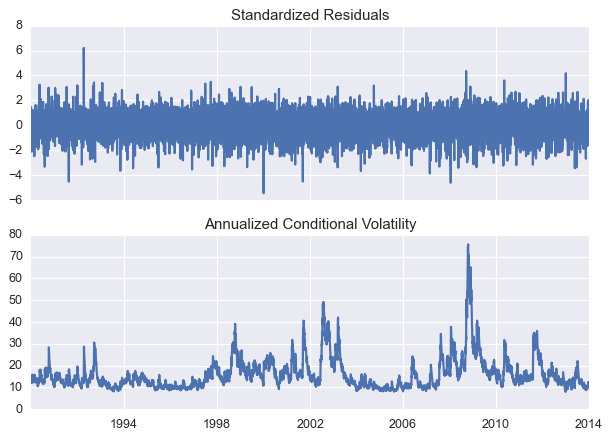

In [4]:
fig = res.plot(annualize='D')

### GJR-GARCH

Additional inputs can be used to construct other models.  This example sets `o` to 1, which includes one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics given by 

$$
\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \gamma \epsilon_{t-1}^2 I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1}^2 
$$

where $I$ is an indicator function that takes the value 1 when its argument is true.

The log likelihood improves substantially with the introduction of an asymmetric term, and the parameter estimate is highly significant.

In [5]:
am = arch_model(returns, p=1, o=1, q=1)
res = am.fit(iter=5)
print(res.summary())

Iteration:      5,   Func. Count:     44,   Neg. LLF: 8408.4226105
Iteration:     10,   Func. Count:     84,   Neg. LLF: 8396.94961262
Iteration:     15,   Func. Count:    121,   Neg. LLF: 8396.81323857
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8396.81323593
            Iterations: 16
            Function evaluations: 128
            Gradient evaluations: 16
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -8396.81
Distribution:                  Normal   AIC:                           16803.6
Method:            Maximum Likelihood   BIC:                           16837.3
                                        No. Observations:                 6262
Date:                Thu, Feb 26 2015

### TARCH/ZARCH

TARCH (also known as ZARCH) model the _volatility_ using absolute values.  This model is specified using `power=1.0` since the default power, 2, corresponds to variance processes that evolve in squares.

The volatility process in a TARCH model is given by 

$$
\sigma_t  =  \omega + \alpha \left|\epsilon_{t-1}\right| + \gamma \left|\epsilon_{t-1}\right| I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1} 
$$

More general models with other powers ($\kappa$) have volatility dynamics given by 

$$
\sigma_t^\kappa   = \omega + \alpha \left|\epsilon_{t-1}\right|^\kappa + \gamma \left|\epsilon_{t-1}\right|^\kappa I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1}^\kappa 
$$

where the conditional variance is $\left(\sigma_t^\kappa\right)^{2/\kappa}$.

The TARCH model also improves the fit, although the change in the log likelihood is less dramatic.

In [6]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0)
res = am.fit(iter=5)
print(res.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 8419.53022235
Iteration:     10,   Func. Count:     88,   Neg. LLF: 8387.51163626
Iteration:     15,   Func. Count:    124,   Neg. LLF: 8386.8106626
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8386.81066261
            Iterations: 15
            Function evaluations: 124
            Gradient evaluations: 15
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -8386.81
Distribution:                  Normal   AIC:                           16783.6
Method:            Maximum Likelihood   BIC:                           16817.3
                                        No. Observations:                 6262
Date:                Thu, Feb 26 2015

### Student's T Errors

Financial returns are often heavy tailed, and a Student's T distribution is a simple method to capture this feature.  The call to `arch` changes the distribution from a Normal to a Students's T.

The standardized residuals appear to be heavy tailed with an estimated degree of freedom near 10.  The log-likelihood also shows a large increase.

In [7]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0, dist='StudentsT')
res = am.fit(iter=5)
print(res.summary())

Iteration:      5,   Func. Count:     51,   Neg. LLF: 8366.06354471
Iteration:     10,   Func. Count:     95,   Neg. LLF: 8336.78563965
Iteration:     15,   Func. Count:    138,   Neg. LLF: 8336.48677997
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8336.48677041
            Iterations: 16
            Function evaluations: 147
            Gradient evaluations: 16
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                    Adj Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -8336.49
Distribution:      Standardized Student's t   AIC:                           16685.0
Method:                  Maximum Likelihood   BIC:                           16725.4
                                              No. Observations:                

## Building a Model From Components

Models can also be systematically assembled from the three model components:

* A mean model (`arch.mean`)
    * Zero mean (`ZeroMean`) - useful if using residuals from a model estimated separately
    * Constant mean (`ConstantMean`) - common for most liquid financial assets
    * Autoregressive (`ARX`) with optional exogenous regressors
    * Heterogeneous (`HARX`) autoregression with optional exogenous regressors
    * Exogenous regressors only (`LS`)
* A volatility process (`arch.volatility`)
    * ARCH (`ARCH`)
    * GARCH (`GARCH`)
    * GJR-GARCH (`GARCH` using `o` argument) 
    * TARCH/ZARCH (`GARCH` using `power` argument set to `1`)
    * Power GARCH and Asymmetric Power GARCH (`GARCH` using `power`)
    * Heterogeneous ARCH (`HARCH`)
    * Parameterless Models
        * Exponentially Weighted Moving Average Variance, known as RiskMetrics (`EWMAVariance`)
        * Weighted averages of EWMAs, known as the RiskMetrics 2006 methodology (`RiskMetrics2006`)
* A distribution (`arch.distribution`)
    * Normal (`Normal`)
    * Standardized Students's T (`StudentsT`)

### Mean Models

The first choice is the mean model.  For many liquid financial assets, a constant mean (or even zero) is adequate.  For other series, such as inflation, a more complicated model may be required.  These examples make use of Core CPI downloaded from the [Federal Reserve Economic Data](http://research.stlouisfed.org/fred2/) site.

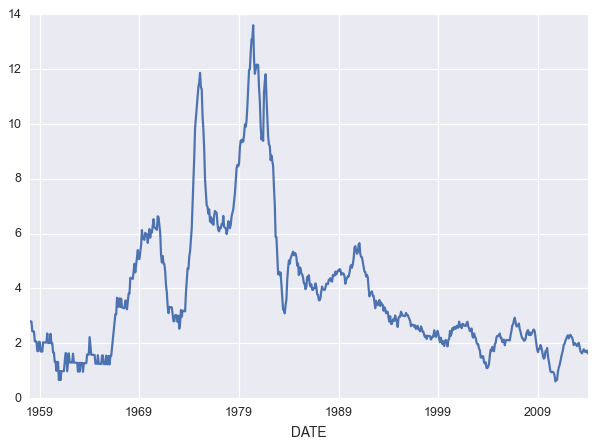

In [8]:
core_cpi = web.DataReader("CPILFESL", "fred", dt.datetime(1957,1,1), dt.datetime(2014,1,1))
ann_inflation = 100 * core_cpi.CPILFESL.pct_change(12).dropna()
fig = ann_inflation.plot()

All mean models are initialized with constant variance and normal errors.  For `ARX` models, the `lags` argument specifies the lags to include in the model.

In [9]:
from arch.univariate import ARX
ar = ARX(ann_inflation, lags = [1, 3, 12])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:               CPILFESL   R-squared:                       0.991
Mean Model:                        AR   Adj. R-squared:                  0.991
Vol Model:          Constant Variance   Log-Likelihood:               -13.4570
Distribution:                  Normal   AIC:                           36.9141
Method:            Maximum Likelihood   BIC:                           59.4728
                                        No. Observations:                  673
Date:                Thu, Feb 26 2015   Df Residuals:                      668
Time:                        22:41:33   Df Model:                            5
                                   Mean Model                                   
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const            0.0424  4.819e-04     88.012 

### Volatility Processes

Volatility processes can be added a a mean model using the `volatility` property.  This example adds an ARCH(5) process to model volatility. The arguments `iter` and `disp` are used in `fit()` to suppress estimation output.

In [10]:
from arch.univariate import ARCH, GARCH
ar.volatility = ARCH(p=5)
res = ar.fit(iter=0, disp='off')
print(res.summary())

                           AR - ARCH Model Results                            
Dep. Variable:               CPILFESL   R-squared:                       0.991
Mean Model:                        AR   Adj. R-squared:                  0.991
Vol Model:                       ARCH   Log-Likelihood:                85.0296
Distribution:                  Normal   AIC:                          -150.059
Method:            Maximum Likelihood   BIC:                          -104.942
                                        No. Observations:                  673
Date:                Thu, Feb 26 2015   Df Residuals:                      663
Time:                        22:41:33   Df Model:                           10
                                   Mean Model                                   
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const            0.0269  4.791e-04     56.172 

Plotting the standardized residuals and the conditional volatility shows some large (in magnitude) errors, even when standardized.

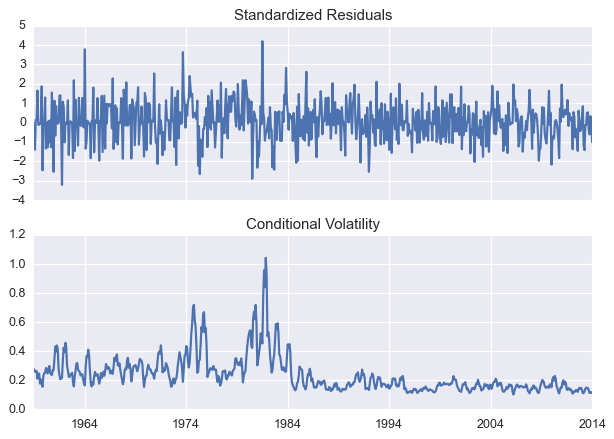

In [11]:
fig = res.plot()

### Distributions

Finally the distribution can be changed from the default normal to a standardized Student's T using the `distribution` property of a mean model.

The Student's t distribution improves the model, and the degree of freedom is estimated to be near 8.

In [12]:
from arch.univariate import StudentsT
ar.distribution = StudentsT()
res = ar.fit(iter=0, disp='off')
print(res.summary())

                              AR - ARCH Model Results                               
Dep. Variable:                     CPILFESL   R-squared:                       0.991
Mean Model:                              AR   Adj. R-squared:                  0.991
Vol Model:                             ARCH   Log-Likelihood:                90.6879
Distribution:      Standardized Student's t   AIC:                          -159.376
Method:                  Maximum Likelihood   BIC:                          -109.747
                                              No. Observations:                  673
Date:                      Thu, Feb 26 2015   Df Residuals:                      662
Time:                              22:41:34   Df Model:                           11
                                   Mean Model                                   
                   coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------